### Example Dataset

In [1]:
!pip install 'liac-arff>=2.4.0'

In [2]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)
pd.options.display.max_columns = None
pd.concat([train_y.tail(), train_X.tail()], axis=1)

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
835,bad,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,none,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,bad,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,none,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,good,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,none,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,bad,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,none,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,good,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,none,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


### Algorithm Selection and Hyperparameter Tuning

In [3]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import OneHotEncoder as OneHot
from lale.lib.lale import Project, ConcatFeatures, NoOp
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier as XGBoost
from lale import wrap_imported_operators
wrap_imported_operators()

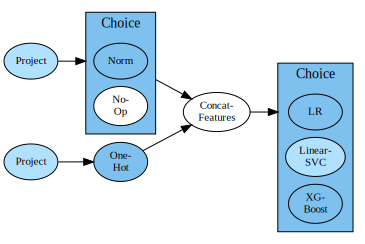

In [4]:
from lale.operators import make_pipeline, make_union

planned_pipeline = make_pipeline(
    make_union(
        make_pipeline(Project(columns={'type': 'number'}), Norm | NoOp),
        make_pipeline(Project(columns={'type': 'string'}), OneHot)),
    LR | LinearSVC(dual=False)| XGBoost)
planned_pipeline.visualize()

In [5]:
from lale.lib.lale import Hyperopt
trained_pipeline = planned_pipeline.auto_configure(
    train_X, train_y, Hyperopt, cv=3, max_evals=10)

100%|███████| 10/10 [04:29<00:00, 26.90s/trial, best loss: -0.7522087871022848]


### Displaying Automation Results

In [6]:
from sklearn.metrics import accuracy_score
predictions = trained_pipeline.predict(test_X)
print(f'accuracy {accuracy_score(test_y, predictions):.1%}')

accuracy 71.2%


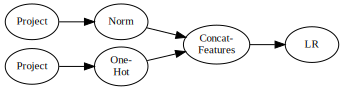

In [7]:
trained_pipeline.visualize()

In [8]:
trained_pipeline.pretty_print(ipython_display=True, show_imports=False)

```python
project_0 = Project(columns={"type": "number"})
project_1 = Project(columns={"type": "string"})
lr = LR(
    intercept_scaling=0.3725797779832578,
    max_iter=802,
    multi_class="ovr",
    solver="newton-cg",
    tol=0.009330002379132212,
)
pipeline = (
    ((project_0 >> Norm()) & (project_1 >> OneHot()))
    >> ConcatFeatures()
    >> lr
)
```

### Call for Users and Contributors

- Repository: https://github.com/IBM/lale

- [Guide for scikit-learn users](https://github.com/IBM/lale/blob/master/examples/docs_guide_for_sklearn_users.ipynb)

- [How to add new operators](https://github.com/IBM/lale/blob/master/examples/docs_new_operators.ipynb)

<img src="https://github.com/IBM/lale/raw/master/docs/img/lale_logo.jpg" style="width:300px" align="left">

### Grammar Example

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures as PolyFeat
wrap_imported_operators()

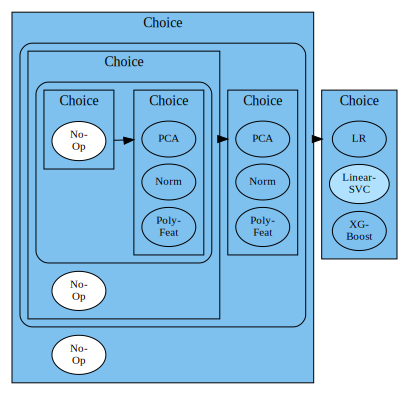

In [10]:
from lale.grammar import Grammar

g = Grammar()

g.start    = make_pipeline(g.rec_tfms, g.prim_est)
g.rec_tfms = NoOp | make_pipeline(g.rec_tfms, g.prim_tfm)
g.prim_tfm = PCA | Norm | PolyFeat
g.prim_est = LR | LinearSVC(dual=False) | XGBoost

unrolled = g.unfold(3)
unrolled.visualize()

In [11]:
unrolled.pretty_print(ipython_display=True, show_imports=False)

```python
linear_svc = LinearSVC(dual=False)
pipeline = (
    NoOp
    | (NoOp | (NoOp) >> (PCA | Norm | PolyFeat)) >> (PCA | Norm | PolyFeat)
) >> (LR | linear_svc | XGBoost)
```